# **Project Name**    -  Glassdoor

##### **Project Type**    - Regression
##### **Contribution**    - Individual

# **Project Summary -**

This project leverages job postings data from Glassdoor.com (2017) to predict salaries for various tech job positions. The dataset includes key features such as job title, company size, and job location, which can be used to identify salary trends, compare roles across industries, and provide valuable insights into compensation expectations.

# **GitHub Link -**

# **Problem Statement**

- How does salary vary by job position(e.g., Data Scientist, DevOPs Engineer)?
- What is the impact of company size on salary levels?
- How do salaries differ by location(e.g., San Francisco, New York)?
- Can we build predictive model to estimate salaries based on job attributes?

By analysing this dataset, we can predict salary ranges, uncover market trends and provide insights to tech professionals and organizations

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.impute import SimpleImputer
sns.set_palette("pastel") 

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso

import pickle

In [9]:
#Import the dataset
df = pd.read_csv('glassdoor_jobs.csv')

In [10]:
#Read the dataset head
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [11]:
# Check dataset shape 
df.shape

(956, 15)

In [12]:
# Check Data types 
print(df.dtypes)

Unnamed: 0             int64
Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
dtype: object


In [13]:
# Droping index column
df = df.drop(columns=['Unnamed: 0'])

In [14]:
# Removing the -1 in the salary estimate column
df = df[df['Salary Estimate']!= '-1']

In [15]:
# Removing the glassdoor est text in the salary column
df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.split('(')[0])

In [16]:
# Removing the k and $ sign from the Salary Estimate
df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('K','').replace('$',''))

In [17]:
# Removing Per hour & Employee provided salary text in Salary Estimated Column
df['PerHour'] = df['Salary Estimate'].str.contains('per hour', case=False).astype(int)
df['Employee'] = df['Salary Estimate'].str.contains('employer provided salary', case=False).astype(int)

# Then, clean up the column in a single call with str.replace
df['Salary Estimate'] = (df['Salary Estimate']
                         .str.replace('per hour', '', case=False)
                         .str.replace('employer provided salary[:]', '', case=False, regex=True)
                         .str.strip()) 

In [18]:
# Create Minimum & maximum range salary using 'Salary Estimate'
df['Min_Salary'] = df['Salary Estimate'].apply(lambda x: int(x.split('-')[0]))
df['Max_Salary'] = df['Salary Estimate'].apply(lambda x: int(x.split('-')[1]))

In [19]:
# Assign average salary value to 'Salry Estimate' column
df['average_salary']= (df['Min_Salary'] + df['Max_Salary'])/2

In [20]:
# Drop Minimum & Maximum Salary columns
df.drop(['Min_Salary','Max_Salary'] , axis =1)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,PerHour,Employee,average_salary
0,Data Scientist,53-91,"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,72.0
1,Healthcare Data Scientist,63-112,What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,87.5
2,Data Scientist,80-90,"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,85.0
3,Data Scientist,56-97,*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,76.5
4,Data Scientist,86-143,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,114.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,"Sr Scientist, Immuno-Oncology - Oncology",58-111,Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",0,0,84.5
951,Senior Data Engineer,72-133,THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",0,0,102.5
952,"Project Scientist - Auton Lab, Robotics Institute",56-91,The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1,0,0,73.5
953,Data Science Manager,95-160,Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,0,0,127.5


In [21]:
# Clean 'Company Name'
df['Company Name'] = df['Company Name'].str.extract(r'^(.*)\n')

In [22]:
# Clean 'Location'
df[['location', 'country']] = df['Location'].str.split(', ', n=1, expand=True)
# drop the cleaned helper column
df.drop(columns=['Location'], inplace=True)

In [23]:
# Clean 'Headquarters'
df[['Headquarters_location', 'Headquarters_country']] = df['Headquarters'].str.split(', ', n=1, expand=True)
# drop the cleaned helper column
df.drop(columns=['Headquarters'], inplace=True)

In [24]:
# Clean 'Size'
# Remove ' employees' suffix
df['Size'] = df['Size'].str.replace(' employees', '', regex=False)

# Split into min and max employee count
df[['min_employees', 'max_employees']] = df['Size'].str.split(' to ', expand=True)

# Convert to numeric (optional but recommended)
df['min_employees'] = pd.to_numeric(df['min_employees'], errors='coerce')
df['max_employees'] = pd.to_numeric(df['max_employees'], errors='coerce')

# drop the cleaned helper column
df.drop(columns=['Size'], inplace=True)

In [25]:
# Create average employees size column
df['average_employees'] = (df['min_employees'] + df['max_employees']) / 2

In [26]:
# clean 'Revenue'
# Step 1: Remove '$', '(USD)', and extra spaces
df['Revenue'] = df['Revenue'].str.replace(r'[\$,]', '', regex=True) \
                                   .str.replace(r'\s*\(USD\)', '', regex=True) \
                                   .str.strip()

df[['min_str', 'max_str']] = df['Revenue'].str.extract(r'(\d+)\s+to\s+(\d+)')
df['min_revenue'] = df['min_str'].astype(float) 
df['max_revenue'] = df['max_str'].astype(float) 

df.drop(columns=['Revenue', 'min_str', 'max_str'], inplace=True)

In [27]:
# Remove'-1' from 'Rating' & impute it with 'mode' value
mode_rating = df.loc[df['Rating'] != -1, 'Rating'].mode()[0]

#replace '-1' with 'mode'
df['Rating'] = df['Rating'].replace(-1, mode_rating)

In [28]:
# Calcuate age of company using 'Founded' column
df['Age'] = df['Founded'].apply(lambda x: x if x<1 else 2025-x)

In [29]:
# Parsing the Job Description for key words like(python, excel etc)
# for python
df['Python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['RStudio'] = df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() or 'r_studio' in x.lower() else 0)
# For Spark
df['Spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
# For AWS
df['AWS'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
# For Excel
df['Excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
# For Tableau
df['Tableau'] = df['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)
# For SQL
df['SQL'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
# For Hadoop
df['Hadoop'] = df['Job Description'].apply(lambda x: 1 if 'hadoop' in x.lower() else 0)

In [30]:
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), '% missing': (df.isnull().mean() * 100).round(2)})
missing_data

,total_missing,% missing
Job Title,0,0.00
Salary Estimate,0,0.00
Job Description,0,0.00
Rating,0,0.00
Company Name,11,1.48
Founded,0,0.00
Type of ownership,0,0.00
Industry,0,0.00
Sector,0,0.00
Competitors,0,0.00


In [31]:
# fill 'unknown' for 'nan' value
df = df.fillna('unknown')

In [32]:
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), '% missing': (df.isnull().mean() * 100).round(2)})
missing_data

,total_missing,% missing
Job Title,0,0.0
Salary Estimate,0,0.0
Job Description,0,0.0
Rating,0,0.0
Company Name,0,0.0
Founded,0,0.0
Type of ownership,0,0.0
Industry,0,0.0
Sector,0,0.0
Competitors,0,0.0


In [33]:
# Separate by dtype
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print categorized columns
print("Column Categories:")
print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Columns ({len(numerical_cols)}): {numerical_cols}")

Column Categories:
Categorical Columns (17): ['Job Title', 'Salary Estimate', 'Job Description', 'Company Name', 'Type of ownership', 'Industry', 'Sector', 'Competitors', 'location', 'country', 'Headquarters_location', 'Headquarters_country', 'min_employees', 'max_employees', 'average_employees', 'min_revenue', 'max_revenue']
Numerical Columns (14): ['Rating', 'Founded', 'Min_Salary', 'Max_Salary', 'average_salary', 'Age', 'Python', 'RStudio', 'Spark', 'AWS', 'Excel', 'Tableau', 'SQL', 'Hadoop']


# Univariate Analysis

In [35]:
# Visualize numerical columns
def visualize_numeric_columns(dataframe, num_cols):
    for col in num_cols:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        
        # Histogram
        sns.histplot(data=dataframe, x=col, kde=True, ax=axs[0])
        axs[0].set_title(f'Distribution of {col}')
        
        # Boxplot
        sns.boxplot(x=dataframe[col], ax=axs[1])
        axs[1].set_title(f'Boxplot of {col}')
        
        plt.tight_layout()
        plt.show()

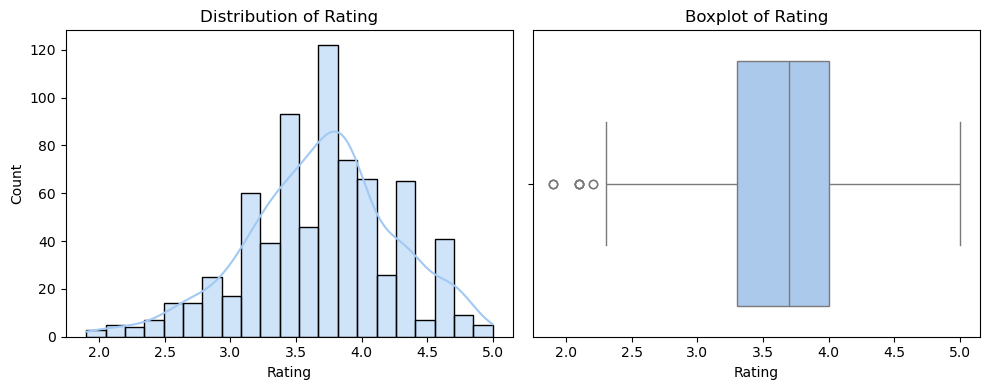

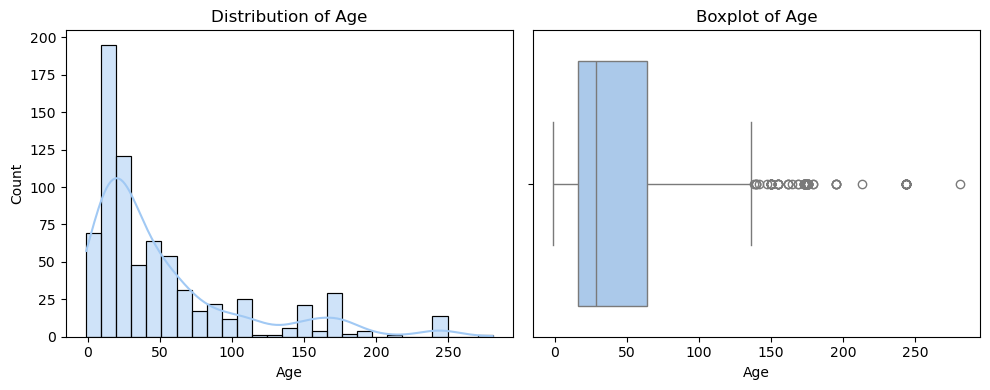

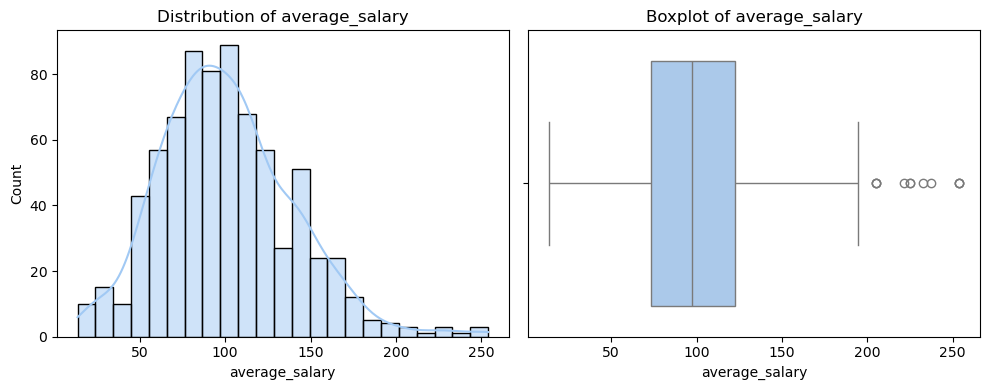

In [36]:
visualize_numeric_columns(df,['Rating', 'Age', 'average_salary'])

### Handle outliers using IQR and Capping Method

In [38]:

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap values at lower and upper bounds
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col]) 
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("Outliers have been capped using IQR.")

Outliers have been capped using IQR.


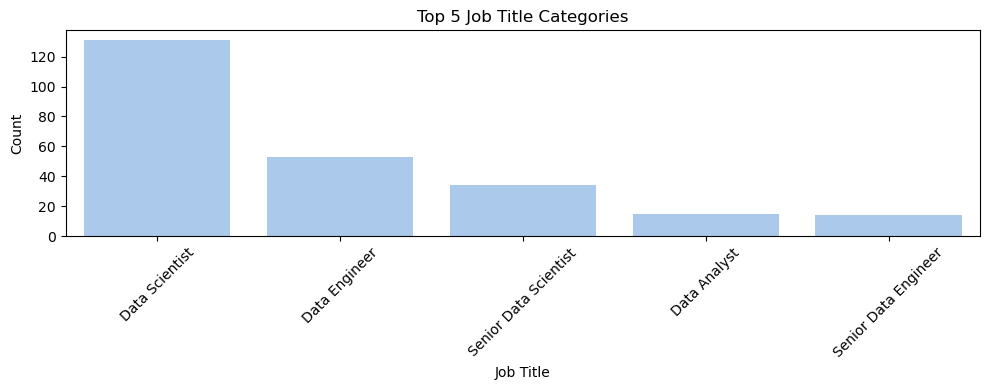

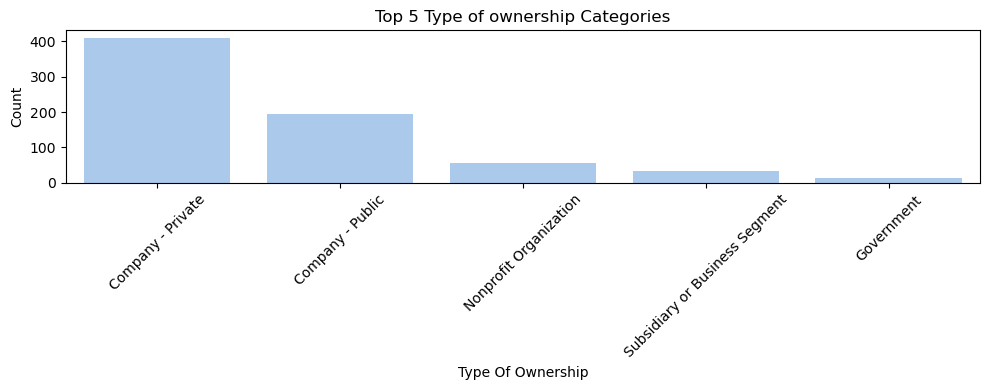

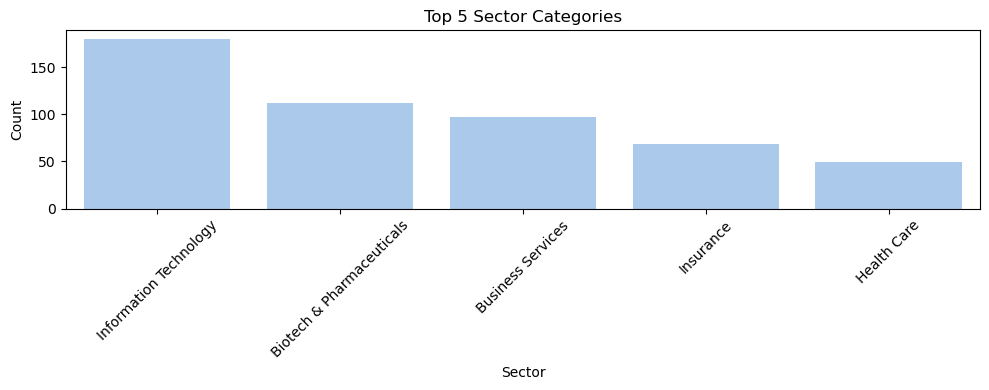

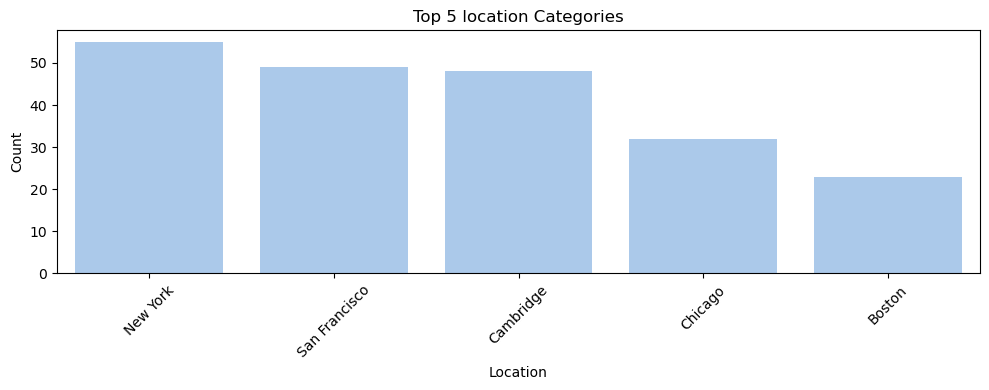

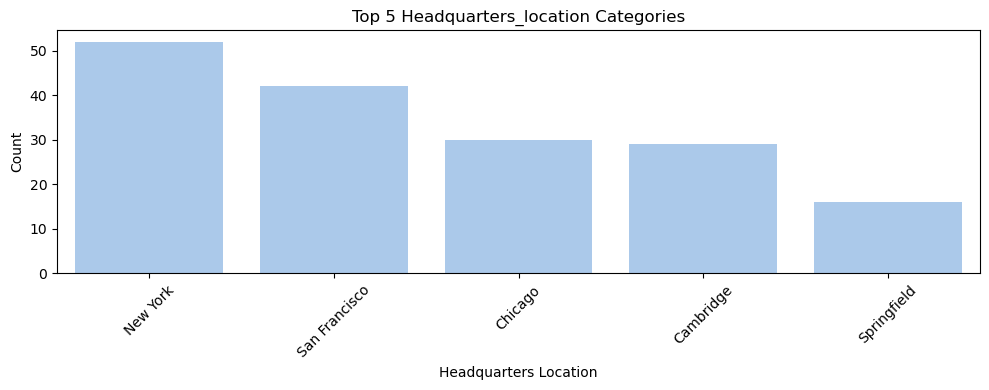

In [39]:
# Visualize categorical columns
categorical_columns_boxplot = ['Job Title', 'Type of ownership', 'Sector', 'location', 'Headquarters_location']
top_n = 5

# Plot each categorical column
for col in categorical_columns_boxplot:
    # Filter out 'unknown'
    df_filtered = df[df[col] != 'unknown']
    # Get top N categories
    top_categories = df[col].value_counts().nlargest(top_n).index
    filtered_df = df[df[col].isin(top_categories)]
    
    # Plot
    plt.figure(figsize=(10, 4))
    sns.countplot(data=filtered_df, x=col, order=top_categories)
    plt.title(f'Top {top_n} {col} Categories')
    plt.xticks(rotation=45)
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

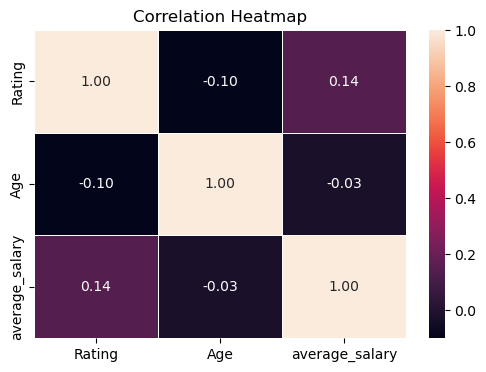

In [40]:
# Correlation Heatmap (for linear relationships)
features = ['Rating', 'Age', 'average_salary']
plt.figure(figsize=(6, 4))
corr = df[features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Bivariate Analysis¶

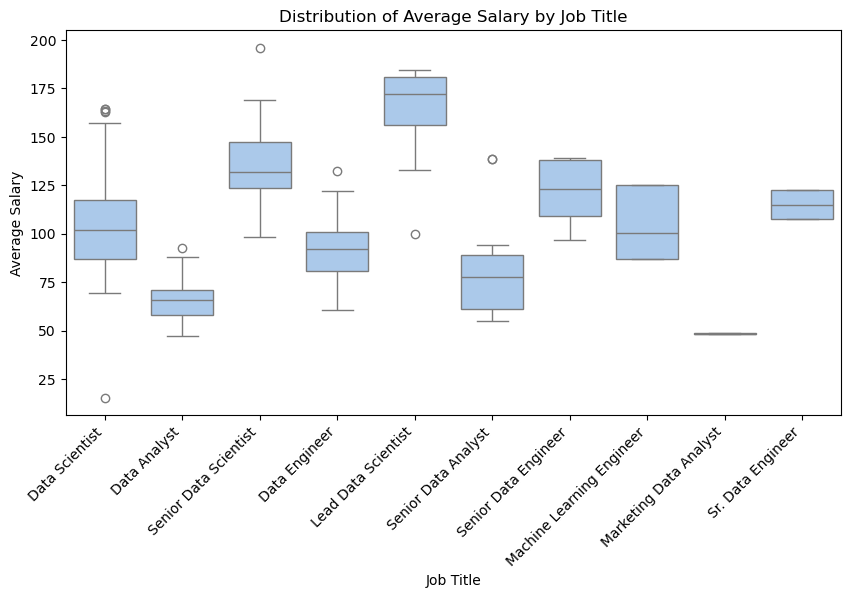

In [42]:
#Filter to job titles with at least 5 samples
filtered_df = df.groupby('Job Title')['Job Title'].transform('count') >= 5
filtered_df = df[filtered_df]
# If you have many job titles, it's often helpful to show only the Top 10 by frequency
top_10_jobs = filtered_df['Job Title'].value_counts().nlargest(10).index
df_new = filtered_df[filtered_df['Job Title'].isin(top_10_jobs)]

plt.figure(figsize=(10, 5))
sns.boxplot(x='Job Title', y='average_salary', data=df_new)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Average Salary by Job Title')
plt.xlabel('Job Title')
plt.ylabel('Average Salary')
plt.show()

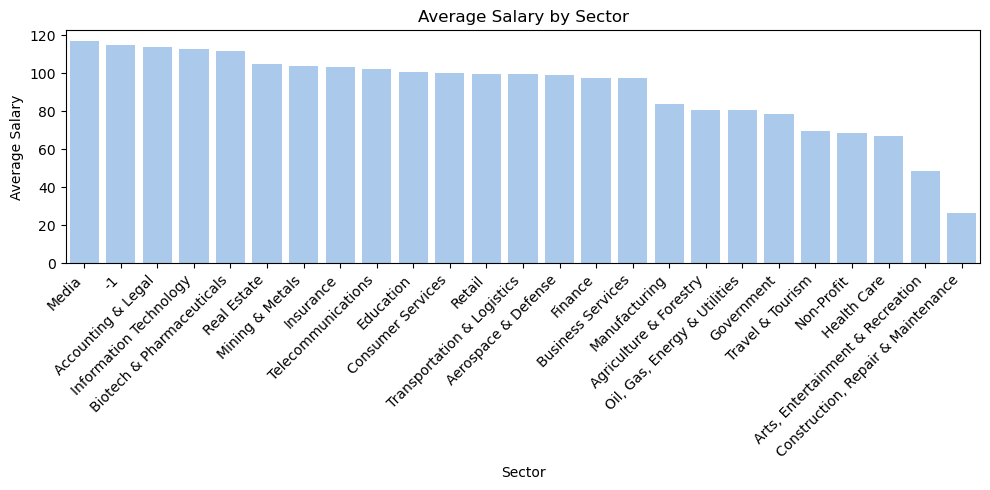

In [43]:
# First compute average salaries by sector
avg_salary_by_sector = df.groupby('Sector')['average_salary'].mean().sort_values(ascending=False)

# Plot a barplot to visualize this
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_salary_by_sector.index, y=avg_salary_by_sector.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Salary by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Salary')
plt.tight_layout()
plt.show()

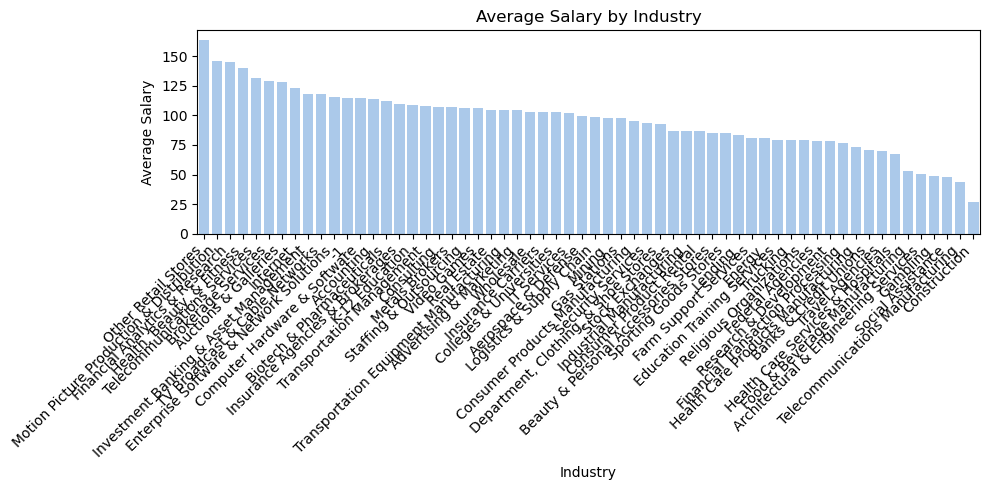

In [44]:
# First compute average salaries by sector
avg_salary_by_industry = df.groupby('Industry')['average_salary'].mean().sort_values(ascending=False)

# Plot a barplot to visualize this
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_salary_by_industry.index, y=avg_salary_by_industry.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Salary by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.tight_layout()
plt.show()

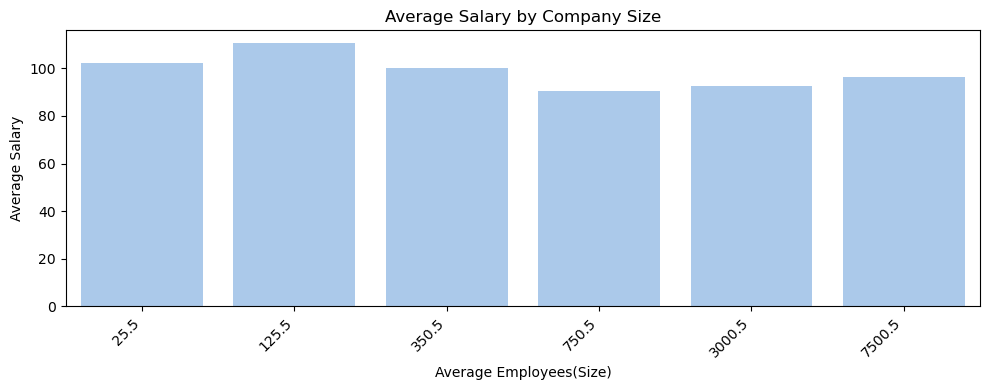

In [45]:
# Filter out rows where average_employees is 'unknown'
filtered_df_em = df[df['average_employees'] != 'unknown']

# First compute average salaries by Company size(i.e., average_employees)
avg_salary_by_size = filtered_df_em.groupby('average_employees')['average_salary'].mean().sort_values(ascending=False)

# Plot a barplot to visualize this
plt.figure(figsize=(10, 4))
sns.barplot(x=avg_salary_by_size.index, y=avg_salary_by_size.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Salary by Company Size')
plt.xlabel('Average Employees(Size)')
plt.ylabel('Average Salary')
plt.tight_layout()
plt.show()

# Model Building

In [47]:
#selecting relevant columns:
data_model = df[['Job Title','Rating', 'Company Name','Type of ownership', 'Sector','average_salary', 'average_employees','location','Age','Python', 'RStudio', 'Spark', 'AWS', 'Excel',
       'Tableau', 'SQL', 'Hadoop']]

In [48]:
data_model.head()

,Job Title,Rating,Company Name,Type of ownership,Sector,average_salary,average_employees,location,Age,Python,RStudio,Spark,AWS,Excel,Tableau,SQL,Hadoop
0,Data Scientist,3.8,Tecolote Research,Company - Private,Aerospace & Defense,72.0,750.5,Albuquerque,52.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Healthcare Data Scientist,3.4,University of Maryland Medical System,Other Organization,Health Care,87.5,unknown,Linthicum,41.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Data Scientist,4.8,KnowBe4,Company - Private,Business Services,85.0,750.5,Clearwater,15.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Data Scientist,3.8,PNNL,Government,"Oil, Gas, Energy & Utilities",76.5,3000.5,Richland,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Data Scientist,2.9,Affinity Solutions,Company - Private,Business Services,114.5,125.5,New York,27.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [49]:
# encode data
df_new  = pd.get_dummies(data_model)
df_new.head()

,Rating,average_salary,Age,Python,RStudio,Spark,AWS,Excel,Tableau,SQL,...,location_Washington,location_Watertown,location_West Palm Beach,location_West Reading,location_Westlake,location_Winston-Salem,location_Winter Park,location_Woburn,location_Woodbridge,location_Worcester
0,3.8,72.0,52.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,3.4,87.5,41.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,4.8,85.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,3.8,76.5,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,2.9,114.5,27.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False


# Model 1: Multi Linear Regression

In [51]:
X= df_new.drop('average_salary', axis=1)
y= df_new['average_salary'].values

In [52]:
# Standardize numerical variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [53]:
# split the data for training and testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [54]:
# Linear Regression 
lm = LinearRegression()
lm.fit(X_train,y_train)

# Predictions
y_pred = lm.predict(X_test)

# Evaluation
print("R² score :", r2_score(y_test, y_pred))
print("Mean Absolute Error :", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error :", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error :", np.sqrt(mean_squared_error(y_test, y_pred)))

R² score : 0.7175668635347286
Mean Absolute Error : 9.951937409673135
Mean Squared Error : 407.631105005942
Root Mean Squared Error : 20.189876299916797


# Model 2: Lasso

In [56]:
# Define Lass and hyperparameter grid
lasso = Lasso()
param_grid = {
    'alpha': [0.1, 1, 10, 100]
}

# Perform grid search
gridLasso = GridSearchCV(lasso, param_grid, scoring='r2', cv=5)
gridLasso.fit(X_train, y_train)

print("Best parameters :", gridLasso.best_params_)
print("Best cross-validated R² :", gridLasso.best_score_)

# Final evaluation
y_pred = gridLasso.predict(X_test)

print("Test R² :", r2_score(y_test, y_pred))
print("Mean Absolute Error :", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error :", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error :", np.sqrt(mean_squared_error(y_test, y_pred)))

Best parameters : {'alpha': 0.1}
Best cross-validated R² : 0.6728070936485402
Test R² : 0.7516822540751928
Mean Absolute Error : 9.843825309703181
Mean Squared Error : 358.39292241248893
Root Mean Squared Error : 18.931268378333474


# Model 3 :RandomForest Regressor with Hyperparameter Tuning

In [58]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
RForest = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_RF = GridSearchCV(RForest, param_grid, scoring='r2', cv=5)
grid_RF.fit(X_train, y_train)

print("Best parameters (RandomForest) :", grid_RF.best_params_)
print("Best cross-validated R² :", grid_RF.best_score_)

y_pred = grid_RF.predict(X_test)

print("Test R² :", r2_score(y_test, y_pred))
print("Mean Absolute Error :", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error :", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error :", np.sqrt(mean_squared_error(y_test, y_pred)))

# Save best estimator for Random Forest model
best_RandomForest = grid_RF.best_estimator_

Best parameters (RandomForest) : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Best cross-validated R² : 0.6458060696767078
Test R² : 0.6648548206298052
Mean Absolute Error : 14.608073825503356
Mean Squared Error : 483.7095303825504
Root Mean Squared Error : 21.99339742701319


# Model 4: GradientBoosting Regressor with Hyperparameter Tuning

In [60]:
GBoost = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}

gridGboost = GridSearchCV(GBoost, param_grid, scoring='r2', cv=5)
gridGboost.fit(X_train, y_train)

print("Best parameters (GradientBoost) :", gridGboost.best_params_)
print("Best cross-validated R² :", gridGboost.best_score_)

y_pred = gridGboost.predict(X_test)

print("Test R² :", r2_score(y_test, y_pred))
print("Mean Absolute Error :", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error :", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error :", np.sqrt(mean_squared_error(y_test, y_pred)))


Best parameters (GradientBoost) : {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}
Best cross-validated R² : 0.6886396174355814
Test R² : 0.7436468961981468
Mean Absolute Error : 9.623938786820206
Mean Squared Error : 369.99022240190146
Root Mean Squared Error : 19.235129903431936


Linear Regression - Mean CV R²:0.616, Std:0.210
Lasso - Mean CV R²:0.514, Std:0.134
Random Forest - Mean CV R²:0.609, Std:0.152
Gradient Boost - Mean CV R²:0.463, Std:0.090


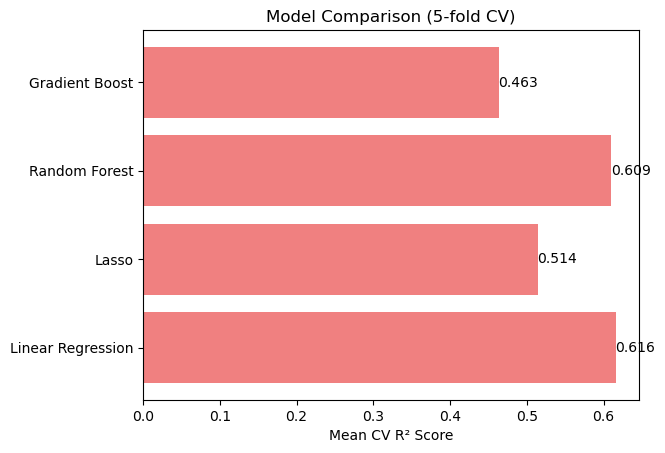

In [61]:
# Define models
models = {
    "Linear Regression": lm, 
    "Lasso": lasso, 
    "Random Forest": RForest, 
    "Gradient Boost": GBoost
}

cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='r2', cv=5)
    cv_scores[name] = scores.mean()
    print(f"{name} - Mean CV R²:{scores.mean():.3f}, Std:{scores.std():.3f}")

# Plotting the results
plt.figure()
plt.barh(y=list(cv_scores.keys()), width=list(cv_scores.values()), color='lightcoral')
plt.xlabel('Mean CV R² Score')
plt.title('Model Comparison (5-fold CV)')
for i, (model, score) in enumerate(cv_scores.items()):
    plt.text(score, i, f'{score:.3f}', va='center')
plt.show()

Observation:
- Linear Regression performs the best with the highest Mean CV R² (0.61), although it shows a large variance (std 0.21), which suggests inconsistency across different folds.
- Random Forest also has the best Highest Mean CV R² (0.61),with lower standard deviation (0.15), indicating more stability, so we will select Random Forest Regressor model for our Prediction.

# Productionization

In [64]:
# Save the best Lasso model to a pickle file
with open("RandomForest_best_model.pkl", "wb") as f:
    pickle.dump(best_RandomForest, f)

print("Best model successfully saved to 'RandomForest_best_model.pkl'")

Best model successfully saved to 'RandomForest_best_model.pkl'
